# Kaggle Dogs vs. Cats Redux: Kernels Edition
## My Convolutional Neural Networks Implementation
Task: Distinguish images of dogs from cats 

matplotlib is a python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. (www.matplotlib.org)

In [1]:
%matplotlib inline

Path to sample data:

In [5]:
path = "data/dogs-cats-redux/sample/"

Libraries

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import utils; reload(utils)
from utils import plots

Using Theano backend.


# Use of Pretrained VGG Model

Use a model that has been fully created and which can recognise a wide variety (1,000 categories) of images. 'VGG' won the 2014 Imagenet competition and is a simple model to create and understand. The Python class *Vgg16* offers the functioality to use the VGG 16 model in a straightforward manner.

In [4]:
# Import vgg16 class and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()

Keras reads groups of images and labels in batches, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

In [6]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 199 images belonging to 2 classes.


Each iteration returns both the images themselves, as well as the labels.

In [7]:
imgs,labels = next(batches)

The labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog

In [8]:
print(labels)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


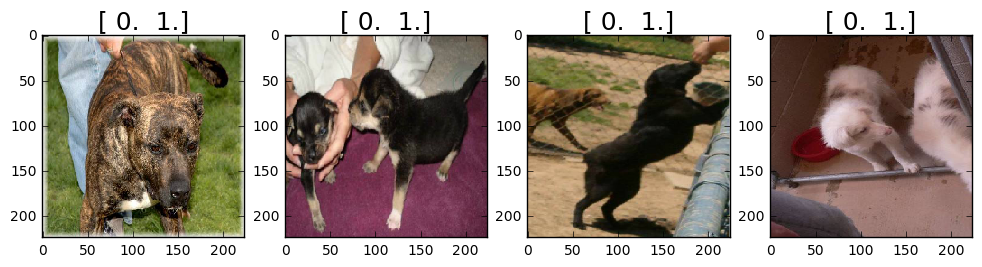

In [9]:
plots(imgs, titles=labels)

Pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [10]:
vgg.predict(imgs, True)

(array([ 0.3443,  0.1977,  0.1161,  0.1279], dtype=float32),
 array([180, 237, 369, 257]),
 [u'American_Staffordshire_terrier',
  u'miniature_pinscher',
  u'siamang',
  u'Great_Pyrenees'])

## Finetune a Dogs vs Cats Model

Change model so that it outputs "cat" vs "dog" instead of one of 1,000 very specific categories. Use a process called "finetuning". We start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call fit() after calling finetune().

Path to all Kaggle training data

In [12]:
path = "data/dogs-cats-redux/"

We create our batches just like before, and making the validation set available as well. A 'batch' (or mini-batch as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [13]:
batch_size=64
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [14]:
vgg.finetune(batches)

Finally, we fit() the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An epoch is one full pass through the training data.)

In [15]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1


KeyboardInterrupt: 